# Solver Configuration

In this notebook I determine a suitable solver configuration and evaluate it on the Solomon benchmark. 

## Contents in this notebook:
1. [Notebook setup](#setup)
2. [Solver configuration](#configuration)
    1. [Configuration dataset](#config_data)
    2. [Search strategies](#search_strategies)
    3. [Search times](#search_times)
    4. [Storage formats](#storage_formats)
3. [Solver evaluation](#evaluation)

## 1. Notebook setup <a name="setup"></a>

In [1]:
# Install required packages.
# !pip install requirements.txt

# Change directory to main project folder.
import os
print(f'This folder: {os.getcwd()}')
os.chdir("..")
print(f'Project folder: {os.getcwd()}\n')

# Import packages.
import routing
import generation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from functools import reduce
import time

This folder: C:\Users\muell\thesis_main\thesis_code\notebooks
Project folder: C:\Users\muell\thesis_main\thesis_code



## 2. Solver Configuration <a name="configuration"></a>

### 2.1. Configuration dataset <a name="config_data"></a>

In [2]:
# # first I generate an empty dataset of 50 instances without solutions

# path = 'data/config/config_notsolved/'

# generation.generate_dataset(
#     path=path, 
#     num_instances=60, 
#     start_count=1, 
#     variant='cvrptw', 
#     verbose=False,
#     solved=False)
# print('done')

In [2]:
# Now I analyze the properties of the empty data to see if it is a representative sample

path = 'data/config/config_notsolved/'

df = routing.load_dataset(
    path=path,
    filetype='pickle', 
    num_instances='all', 
    info='combined', 
    verbose=10)

print(df.shape)
df.head(3)

10 instances loaded (0.02s)
20 instances loaded (0.04s)
30 instances loaded (0.05s)
40 instances loaded (0.07s)
50 instances loaded (0.09s)
(50, 26)


,variant,distance_metric,depot,locations,demands,vehicle_capacities,service_times,time_windows,max_time,wait_time,...,depot_pos,loc_distr,dem_distr,cap_ratio,avg_route_size,possible_rounds,st_distr,tw_share,tw_center_distr,tw_width_distr
0,cvrptw,euclidean,0,"[[558.5562, 442.815], [737.2942, 44.2815], [44...","[0, 94, 79, 69, 80, 54, 73, 95, 81, 86, 99, 70...","[2234, 2234, 2234, 2234, 2234, 2234, 2234, 223...","[0, 22, 274, 501, 482, 613, 693, 557, 58, 650,...","[[0.0, 10675.8181], [7276.1396, 10488.8095], [...",10675.8181,10675.8181,...,central,uniform_clustered,highval_lowcv,0.5577,30.6735,2.6653,uniform,0.3907,uniform,medium
1,cvrptw,euclidean,0,"[[385.561, 302.1726], [570.6303, 350.5202], [6...","[0, 2, 7, 5, 7, 3, 1, 6, 4, 8, 1, 6, 7, 8, 5, ...","[367, 367, 367, 367, 367, 367, 367, 367, 367, ...","[0, 49, 173, 124, 173, 74, 24, 148, 99, 198, 2...","[[0.0, 9885.482], [0.0, 9885.482], [0.0, 9885....",9885.4820,9885.4820,...,central,cavity_dispersion,lowval_highcv,0.7368,72.2064,3.5935,proportional,0.4362,three_peaks,uniform
2,cvrptw,euclidean,0,"[[173.6648, 507.2017], [279.7933, 600.1887], [...","[0, 8, 5, 6, 6, 7, 7, 5, 9, 5, 9, 8, 7, 9, 6, ...","[449, 449, 449, 449, 449, 449, 449, 449, 449, ...","[0, 416, 416, 416, 416, 416, 416, 416, 416, 41...","[[0.0, 9186.1015], [4045.0543, 5663.7182], [29...",9186.1015,9186.1015,...,loc_distr,squeezed,lowval_lowcv,0.7563,63.5292,2.5374,unitary,0.8337,uniform,uniform


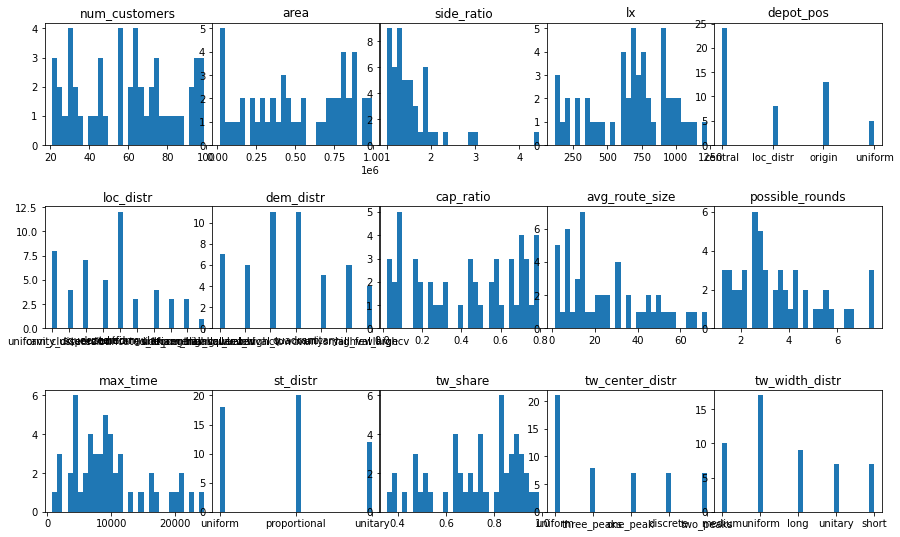

In [3]:
# Analze instance characteristics to check representativeness

fig, axs = plt.subplots(3,5, figsize=(15, 9), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.001)

axs = axs.ravel()

#df.columns
variables = ['num_customers', 'area', 'side_ratio', 'lx','depot_pos', 'loc_distr', 
             'dem_distr','cap_ratio', 'avg_route_size', 'possible_rounds',
             'max_time', 'st_distr','tw_share', 'tw_center_distr', 'tw_width_distr'] 

for i in range(15): 
    axs[i].hist(df[variables[i]], bins=30)
    axs[i].set_title(variables[i])
    
plt.tight_layout()
plt.show()

### 2.2. Search strategies <a name="search_strategies"></a>

In [4]:
# first I solve using a variety of search params (see py modules next to data)

In [3]:
# load data comparison data
path_from = 'data/config/config_params/solved/'
df = routing.load_dataset(path=path_from, filetype='pickle', info='combined', verbose=200)

# Add some variables
df['num_vehicles_used'] = [sum([1 for route in df['solution_routes'][i]  if len(route) > 2]) for i in range(df.shape[0])]
df['best_distance'] = [min(df[df['name'] == name]['solution_distance']) for name in df['name']]
df['percentage_error'] = 100* (df['solution_distance'] / df['best_distance'] - 1)

# Show data
df = df[['name', 'first_solution', 'local_search', 'percentage_error', 'solution_distance', 'best_distance', 'num_vehicles_used']]
print(df.shape)
df.head(16)

200 instances loaded (1.3s)
400 instances loaded (2.11s)
600 instances loaded (2.83s)
800 instances loaded (3.69s)
(800, 7)


,name,first_solution,local_search,percentage_error,solution_distance,best_distance,num_vehicles_used
0,cvrptw000001,CHRISTOFIDES,GREEDY_DESCENT,10.642891,7502.96,6781.24,4
1,cvrptw000001,CHRISTOFIDES,GUIDED_LOCAL_SEARCH,0.000000,6781.24,6781.24,4
2,cvrptw000001,CHRISTOFIDES,SIMULATED_ANNEALING,10.642891,7502.96,6781.24,4
3,cvrptw000001,CHRISTOFIDES,TABU_SEARCH,3.936153,7048.16,6781.24,4
4,cvrptw000001,LOCAL_CHEAPEST_INSERTION,GREEDY_DESCENT,7.715551,7304.45,6781.24,4
5,cvrptw000001,LOCAL_CHEAPEST_INSERTION,GUIDED_LOCAL_SEARCH,0.000000,6781.24,6781.24,4
6,cvrptw000001,LOCAL_CHEAPEST_INSERTION,SIMULATED_ANNEALING,5.469354,7152.13,6781.24,4
7,cvrptw000001,LOCAL_CHEAPEST_INSERTION,TABU_SEARCH,5.115436,7128.13,6781.24,4
8,cvrptw000001,PARALLEL_CHEAPEST_INSERTION,GREEDY_DESCENT,7.425043,7284.75,6781.24,4
9,cvrptw000001,PARALLEL_CHEAPEST_INSERTION,GUIDED_LOCAL_SEARCH,0.024774,6782.92,6781.24,4


In [4]:
# Compare search strategy parameter combinations
df.groupby(by=['first_solution', 'local_search']).mean()#.sort_values(by=['percentage_error'])

percentage_error  \
first_solution              local_search                            
CHRISTOFIDES                GREEDY_DESCENT               6.203472   
                            GUIDED_LOCAL_SEARCH          0.865805   
                            SIMULATED_ANNEALING          5.077710   
                            TABU_SEARCH                  2.287710   
LOCAL_CHEAPEST_INSERTION    GREEDY_DESCENT               6.077994   
                            GUIDED_LOCAL_SEARCH          0.988110   
                            SIMULATED_ANNEALING          5.314195   
                            TABU_SEARCH                  2.560865   
PARALLEL_CHEAPEST_INSERTION GREEDY_DESCENT               9.069059   
                            GUIDED_LOCAL_SEARCH          1.104554   
                            SIMULATED_ANNEALING          7.677572   
                            TABU_SEARCH                  2.730799   
PATH_CHEAPEST_ARC           GREEDY_DESCENT               6.077994   
                            GUIDED_LOCAL_SEARCH          0.807740   
                            SIMULATED_ANNEALING          5.314195   
                            TABU_SEARCH                  2.406577   

                                                 solution_distance  \
first_solution              local_search                             
CHRISTOFIDES                GREEDY_DESCENT               8041.2300   
                            GUIDED_LOCAL_SEARCH          7671.8410   
                            SIMULATED_ANNEALING          7970.9602   
                            TABU_SEARCH                  7767.6886   
LOCAL_CHEAPEST_INSERTION    GREEDY_DESCENT               8064.5754   
                            GUIDED_LOCAL_SEARCH          7664.1174   
                            SIMULATED_ANNEALING          8011.9018   
                            TABU_SEARCH                  7789.4510   
PARALLEL_CHEAPEST_INSERTION GREEDY_DESCENT               8242.8596   
                            GUIDED_LOCAL_SEARCH          7684.5126   
                            SIMULATED_ANNEALING          8184.8384   
                            TABU_SEARCH                  7799.4038   
PATH_CHEAPEST_ARC           GREEDY_DESCENT               8064.5754   
                            GUIDED_LOCAL_SEARCH          7653.6126   
                            SIMULATED_ANNEALING          8011.9018   
                            TABU_SEARCH                  7782.5554   

                                                 best_distance  \
first_solution              local_search                         
CHRISTOFIDES                GREEDY_DESCENT           7594.8638   
                            GUIDED_LOCAL_SEARCH      7594.8638   
                            SIMULATED_ANNEALING      7594.8638   
                            TABU_SEARCH              7594.8638   
LOCAL_CHEAPEST_INSERTION    GREEDY_DESCENT           7594.8638   
                            GUIDED_LOCAL_SEARCH      7594.8638   
                            SIMULATED_ANNEALING      7594.8638   
                            TABU_SEARCH              7594.8638   
PARALLEL_CHEAPEST_INSERTION GREEDY_DESCENT           7594.8638   
                            GUIDED_LOCAL_SEARCH      7594.8638   
                            SIMULATED_ANNEALING      7594.8638   
                            TABU_SEARCH              7594.8638   
PATH_CHEAPEST_ARC           GREEDY_DESCENT           7594.8638   
                            GUIDED_LOCAL_SEARCH      7594.8638   
                            SIMULATED_ANNEALING      7594.8638   
                            TABU_SEARCH              7594.8638   

                                                 num_vehicles_used  
first_solution              local_search                            
CHRISTOFIDES                GREEDY_DESCENT                    8.08  
                            GUIDED_LOCAL_SEARCH               7.94  
                            SIMULATED_ANNEALING               8.06  
           

In [7]:
# Analyze the best result

# load
path_from = 'data/config/config_params/solved/'
df = routing.load_dataset(path=path_from, filetype='pickle', info='combined', verbose=200)

# add variables
df['num_vehicles_used'] = [sum([1 for route in df['solution_routes'][i]  if len(route) > 2]) for i in range(df.shape[0])]
df['best_distance'] = [min(df[df['name'] == name]['solution_distance']) for name in df['name']]
df['percentage_error'] = 100* (df['solution_distance'] / df['best_distance'] - 1)

# reduce to best parameters
df = df[df['first_solution'] == 'PATH_CHEAPEST_ARC']
df = df[df['local_search'] == 'GUIDED_LOCAL_SEARCH']
df = df[['name', 'first_solution', 'local_search', 'percentage_error', 'solution_distance', 'best_distance', 'num_vehicles_used', 'num_customers','cap_ratio', 'avg_route_size', 'possible_rounds']]

# show
df.head(10)

200 instances loaded (0.12s)
400 instances loaded (0.31s)
600 instances loaded (0.52s)
800 instances loaded (0.61s)


,name,first_solution,local_search,percentage_error,solution_distance,best_distance,num_vehicles_used,num_customers,cap_ratio,avg_route_size,possible_rounds
13,cvrptw000001,PATH_CHEAPEST_ARC,GUIDED_LOCAL_SEARCH,0.000000,6781.24,6781.24,4,55,0.5577,30.6735,2.6653
29,cvrptw000051,PATH_CHEAPEST_ARC,GUIDED_LOCAL_SEARCH,1.595260,6917.54,6808.92,4,98,0.7368,72.2064,3.5935
45,cvrptw000003,PATH_CHEAPEST_ARC,GUIDED_LOCAL_SEARCH,0.797393,12008.83,11913.83,8,84,0.7563,63.5292,2.5374
61,cvrptw000004,PATH_CHEAPEST_ARC,GUIDED_LOCAL_SEARCH,0.000000,22939.08,22939.08,11,66,0.1000,6.6000,1.6386
77,cvrptw000005,PATH_CHEAPEST_ARC,GUIDED_LOCAL_SEARCH,4.106579,6003.41,5766.60,5,55,0.4942,27.1810,2.8092
93,cvrptw000006,PATH_CHEAPEST_ARC,GUIDED_LOCAL_SEARCH,5.475943,2042.51,1936.47,8,62,0.7743,48.0066,1.9622
109,cvrptw000007,PATH_CHEAPEST_ARC,GUIDED_LOCAL_SEARCH,0.000000,2030.22,2030.22,2,29,0.5698,16.5242,2.2457
125,cvrptw000008,PATH_CHEAPEST_ARC,GUIDED_LOCAL_SEARCH,0.000000,13713.80,13713.80,6,74,0.6614,48.9436,3.0295
141,cvrptw000052,PATH_CHEAPEST_ARC,GUIDED_LOCAL_SEARCH,1.060121,13533.84,13391.87,7,99,0.5858,57.9942,2.7474
157,cvrptw000010,PATH_CHEAPEST_ARC,GUIDED_LOCAL_SEARCH,1.107080,5687.89,5625.61,5,57,0.2394,13.6458,7.4490


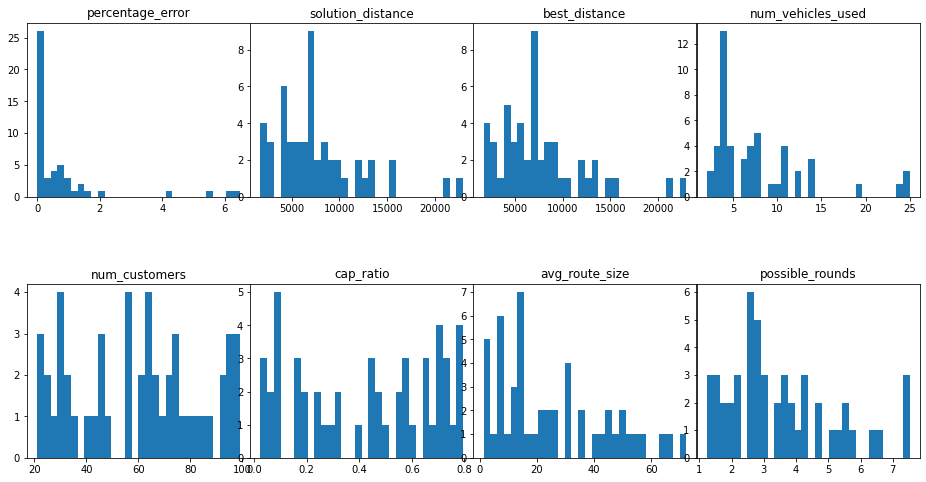

In [8]:
# analyze solution characteristics
fig, axs = plt.subplots(2,4, figsize=(16, 8), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.001)

axs = axs.ravel()

#df.columns
variables = ['percentage_error',
       'solution_distance', 'best_distance', 'num_vehicles_used',
       'num_customers', 'cap_ratio', 'avg_route_size', 'possible_rounds'] 

for i in range(8): 
    axs[i].hist(df[variables[i]], bins=30)
    axs[i].set_title(variables[i])
    
plt.tight_layout()
plt.show()

In [9]:
# Analyze correlations
print(np.corrcoef(df['num_vehicles_used'], df['cap_ratio']))
print(np.corrcoef(df['num_vehicles_used'], df['num_customers']))

[[ 1.         -0.63466313]
 [-0.63466313  1.        ]]
[[1.         0.03669831]
 [0.03669831 1.        ]]


### 2.3. Search times <a name="search_times"></a>

In [10]:
# first I solve using a variety of search times (see py modules next to data)

In [5]:
# load data comparison data
path_from = 'data/config/config_times/solved/'
df = routing.load_dataset(path=path_from, filetype='pickle', info='combined', verbose=200)

# Add some variables
df['num_vehicles_used'] = [sum([1 for route in df['solution_routes'][i]  if len(route) > 2]) for i in range(df.shape[0])]
df['best_distance'] = [min(df[df['name'] == name]['solution_distance']) for name in df['name']]
df['percentage_error'] = 100* (df['solution_distance'] / df['best_distance'] - 1)

# Show data
df = df[['name', 'first_solution', 'local_search', 'time_limit_m', 'percentage_error', 'solution_distance', 'best_distance', 'num_vehicles_used', 'num_customers']]
df.head(10)

200 instances loaded (0.78s)


,name,first_solution,local_search,time_limit_m,percentage_error,solution_distance,best_distance,num_vehicles_used,num_customers
0,cvrptw000001,PATH_CHEAPEST_ARC,GUIDED_LOCAL_SEARCH,1,0.000000,6781.24,6781.24,4,55
1,cvrptw000001,PATH_CHEAPEST_ARC,GUIDED_LOCAL_SEARCH,2,0.000000,6781.24,6781.24,4,55
2,cvrptw000001,PATH_CHEAPEST_ARC,GUIDED_LOCAL_SEARCH,3,0.000000,6781.24,6781.24,4,55
3,cvrptw000001,PATH_CHEAPEST_ARC,GUIDED_LOCAL_SEARCH,4,0.000000,6781.24,6781.24,4,55
4,cvrptw000001,PATH_CHEAPEST_ARC,GUIDED_LOCAL_SEARCH,5,0.000000,6781.24,6781.24,4,55
5,cvrptw000051,PATH_CHEAPEST_ARC,GUIDED_LOCAL_SEARCH,1,3.091920,6917.54,6710.07,4,98
6,cvrptw000051,PATH_CHEAPEST_ARC,GUIDED_LOCAL_SEARCH,2,1.923378,6839.13,6710.07,4,98
7,cvrptw000051,PATH_CHEAPEST_ARC,GUIDED_LOCAL_SEARCH,3,0.001043,6710.14,6710.07,4,98
8,cvrptw000051,PATH_CHEAPEST_ARC,GUIDED_LOCAL_SEARCH,4,0.000000,6710.07,6710.07,4,98
9,cvrptw000051,PATH_CHEAPEST_ARC,GUIDED_LOCAL_SEARCH,5,0.000000,6710.07,6710.07,4,98


In [6]:
# now I compare the different search times
df.iloc[:,:].groupby(by=['time_limit_m']).mean()#.sort_values(by=['percentage_error'])#'first_solution', 'local_search', 

,percentage_error,solution_distance,best_distance,num_vehicles_used,num_customers
time_limit_m,,,,,
1,1.029407,7653.6126,7580.598,7.92,59.44
2,0.395417,7609.7454,7580.598,7.96,59.44
3,0.096046,7590.0104,7580.598,7.94,59.44
4,0.053622,7586.9706,7580.598,7.94,59.44
5,0.000000,7580.5980,7580.598,7.90,59.44


In [13]:
# -> 3s per customer seems to give a resonable tradeoff between computing time and performance

In [14]:
# Analyze the final configuration

# reduce to final configuration
df = df[df['time_limit_m'] == 3]

# Show data
df.head(15)

,name,first_solution,local_search,time_limit_m,percentage_error,solution_distance,best_distance,num_vehicles_used,num_customers
2,cvrptw000001,PATH_CHEAPEST_ARC,GUIDED_LOCAL_SEARCH,3,0.000000,6781.24,6781.24,4,55
7,cvrptw000051,PATH_CHEAPEST_ARC,GUIDED_LOCAL_SEARCH,3,0.001043,6710.14,6710.07,4,98
12,cvrptw000003,PATH_CHEAPEST_ARC,GUIDED_LOCAL_SEARCH,3,0.000000,11906.92,11906.92,8,84
17,cvrptw000004,PATH_CHEAPEST_ARC,GUIDED_LOCAL_SEARCH,3,0.000000,22939.08,22939.08,11,66
22,cvrptw000005,PATH_CHEAPEST_ARC,GUIDED_LOCAL_SEARCH,3,0.000000,5758.48,5758.48,4,55
27,cvrptw000006,PATH_CHEAPEST_ARC,GUIDED_LOCAL_SEARCH,3,0.309349,1945.56,1939.56,8,62
32,cvrptw000007,PATH_CHEAPEST_ARC,GUIDED_LOCAL_SEARCH,3,0.000000,2030.22,2030.22,2,29
37,cvrptw000008,PATH_CHEAPEST_ARC,GUIDED_LOCAL_SEARCH,3,1.783826,13588.67,13350.52,6,74
42,cvrptw000052,PATH_CHEAPEST_ARC,GUIDED_LOCAL_SEARCH,3,1.222615,13487.63,13324.72,7,99
47,cvrptw000010,PATH_CHEAPEST_ARC,GUIDED_LOCAL_SEARCH,3,0.000000,5625.61,5625.61,5,57


### 2.4. Storage format <a name="storage_formats"></a>

In [15]:
### Check equality of storage methods

path = 'data/config/config_params/solved/'

for f in os.listdir(path)[:10]:
    filename = f[:19]
    instance_pickle = routing.load_instance(path+filename+'.pickle')
    instance_txt = routing.load_instance(path+filename+'.txt')
    #assert instance_pickle == instance_txt
    instance_pickle.__eq__(instance_txt, verbose=True) 
    
# pickle and txt are essentially equal
# in some instances, some gen_params might be float instead of np.float, but that is not important
# json was tested separately but found to be larger in size and slower in speed

In [17]:
### Compare times to load from the different filetypes

path_from = 'data/config/config_params/solved/'
num_loads = 10

t0 = time.time()
for i in range(num_loads):
    df = None
    df = routing.load_dataset(path=path_from, filetype='pickle', info='combined', verbose=False)
t1 = time.time()
print(f'pickle: {num_loads*df.shape[0]} instances loaded in {t1-t0}s.')

t0 = time.time()
for i in range(num_loads):
    df = None
    df = routing.load_dataset(path=path_from, filetype='txt', info='combined', verbose=False)
t1 = time.time()
print(f'txt: {num_loads*df.shape[0]} instances loaded in {t1-t0}s.')

# pickle loads faster (because txt needs to be converted back to orinal instance state) so I use it for my analysis, 
# but txt can be easily read without python so I keep it for logging purposes.

pickle: 8000 instances loaded in 6.105679750442505s.
txt: 8000 instances loaded in 9.672354936599731s.


## 3. Solver evaluation <a name="evaluation"></a>

#### Solomon solutions

In [2]:
# Compare solutions for Solomon benchmark of varying accuracy
df_solomon_best = routing.load_solomon_solutions(solution_accuracy='best_known')
df_solomon_opt  = routing.load_solomon_solutions(solution_accuracy='optimal')
df_solomon_heu  = routing.load_solomon_solutions(solution_accuracy='heuristic')
data_frames = [df_solomon_best, df_solomon_opt, df_solomon_heu]
df_solomon = reduce(lambda  left,right: pd.merge(left,right,on=['name'], how='outer'), data_frames)
# df_solomon.sort_values(by=['name'], inplace=True)
# df_solomon.reset_index(drop=True, inplace=True)
df_solomon.head(10)

,name,sol_best_vehicles,sol_best_distance,sol_best_authors,sol_opt_vehicles,sol_opt_distance,sol_opt_authors,sol_heu_vehicles,sol_heu_distance,sol_heu_authors
0,C101.25,3,191.3,KDMSS,3,191.3,KDMSS,NaN,NaN,NaN
1,C201.25,2,214.7,CR+L,2,214.7,CR+L,NaN,NaN,NaN
2,C101.50,5,362.4,KDMSS,5,362.4,KDMSS,NaN,NaN,NaN
3,C201.50,3,360.2,CR+L,3,360.2,CR+L,NaN,NaN,NaN
4,C101.100,10,827.3,KDMSS,10,827.3,KDMSS,10,828.94,RT
5,C201.100,3,589.1,CR+KLM,3,589.1,CR+KLM,3,591.56,RT
6,C102.25,3,190.3,KDMSS,3,190.3,KDMSS,NaN,NaN,NaN
7,C202.25,2,214.7,CR+L,2,214.7,CR+L,NaN,NaN,NaN
8,C102.50,5,361.4,KDMSS,5,361.4,KDMSS,NaN,NaN,NaN
9,C202.50,3,360.2,CR+KLM,3,360.2,CR+KLM,NaN,NaN,NaN


In [3]:
# Compute MAPE for Solomon using average baseline (in-sample)
solomon_solutions = list(df_solomon['sol_best_distance'].dropna().astype(float))
m = np.mean(solomon_solutions)
mape_solomon = np.mean([abs(m/s-1) for s in solomon_solutions])
mape_solomon

0.6124345667331103

#### Solver solutions

In [4]:
# # Use my solver configuration defined in section 2 to solve the Solomon benchmark datset (see path_to below)

# path_from = 'data/benchmarks/solomon_instances/'
# path_to = 'data/config/config_eval/solved/'

# routing.solve_dataset(
#     path_from, 
#     path_to, 
#     filetype='solomon', 
#     first_solution='PATH_CHEAPEST_ARC', 
#     local_search='GUIDED_LOCAL_SEARCH',
#     time_limit_m=3, 
#     verbose=True, 
#     num_inst='all'
# )

In [6]:
# Load solver eval solutions

path_from = 'data/config/config_eval/solved/'
df_solver = routing.load_dataset(
    path_from, 
    filetype='pickle', 
    num_instances='all', 
    info='instance', 
    verbose=50)
df_solver = df_solver[['name', 'solution_distance']]
print(df_solver.shape)
df_solver.head()

50 instances loaded (0.33s)
100 instances loaded (0.52s)
150 instances loaded (0.73s)
(168, 2)


,name,solution_distance
0,C101.100,829.00
1,C101.25,191.82
2,C101.50,363.27
3,C102.100,829.00
4,C102.25,190.75


#### Compare Solomon and solver solutions

In [7]:
# Merge df_solvers with df_opt
df_solomon_opt = routing.load_solomon_solutions(solution_accuracy='optimal')
df_solomon_opt = df_solomon_opt[['name', 'sol_opt_distance']]
df_comparison = pd.merge(df_solver, df_solomon_opt, on='name', how='outer')
df_comparison.head(20)

,name,solution_distance,sol_opt_distance
0,C101.100,829.00,827.3
1,C101.25,191.82,191.3
2,C101.50,363.27,362.4
3,C102.100,829.00,827.3
4,C102.25,190.75,190.3
5,C102.50,362.20,361.4
6,C103.100,828.13,826.3
7,C103.25,190.75,190.3
8,C103.50,362.20,361.4
9,C104.100,870.85,822.9


In [8]:
### Prepare analysis

# drop missing values (no optimal solution known)
df_comparison = df_comparison[(df_comparison['sol_opt_distance'] != '')]
df_comparison.dropna(inplace=True)
df_comparison.reset_index(drop=True, inplace=True)
df_comparison.shape

# convert numbers from str to float
df_comparison['sol_opt_distance'] = df_comparison['sol_opt_distance'].astype(float)

# compute differences and ratios
df_comparison['diff'] = df_comparison['solution_distance'] - df_comparison['sol_opt_distance']
df_comparison['ratio'] = df_comparison['solution_distance'] / df_comparison['sol_opt_distance']
print(df_comparison.shape)#.head(50)

# Create buckets to analyze by
groups = []
num_customers = []
for i in range(df_comparison.shape[0]):
    name = df_comparison.loc[i, 'name']
    if name[-2:] == '25':
        num_customers.append(25)
    elif name[-2:] == '50':
        num_customers.append(50)
    elif name[-2:] == '00':
        num_customers.append(100)
    if name[0] == 'C':
        groups.append('C')
    if name[0] == 'R':
        if name[1] == 'C':
            groups.append('RC')
        else:
            groups.append('R')
df_comparison['num_cust'] = num_customers
df_comparison['group'] = groups
df_comparison.head()

(139, 5)


,name,solution_distance,sol_opt_distance,diff,ratio,num_cust,group
0,C101.100,829.00,827.3,1.70,1.002055,100,C
1,C101.25,191.82,191.3,0.52,1.002718,25,C
2,C101.50,363.27,362.4,0.87,1.002401,50,C
3,C102.100,829.00,827.3,1.70,1.002055,100,C
4,C102.25,190.75,190.3,0.45,1.002365,25,C


In [9]:
### Analyze by bucket

df_grouped_results = df_comparison.groupby(by=['group', 'num_cust']).mean()
df_grouped_results['percentage_error'] = (df_grouped_results['ratio'] - 1) * 100
df_grouped_results

solution_distance  sol_opt_distance       diff     ratio  \
group num_cust                                                             
C     25               202.482353        201.817647   0.664706  1.003257   
      50               361.123529        359.717647   1.405882  1.003930   
      100              719.759412        714.076471   5.682941  1.007899   
R     25               425.549130        424.521739   1.027391  1.002460   
      50               715.446667        709.519048   5.927619  1.008353   
      100             1106.335000       1073.816667  32.518333  1.030650   
RC    25               335.596250        334.756250   0.840000  1.002485   
      50               666.350000        662.613333   3.736667  1.004820   
      100             1262.667143       1220.785714  41.881429  1.034333   

                percentage_error  
group num_cust                    
C     25                0.325671  
      50                0.392988  
      100               0.789940  
R     25                0.245971  
      50                0.835329  
      100               3.064987  
RC    25                0.248474  
      50                0.482042  
      100               3.433323

Average deviation: 0.74%
Minimum deviation: 0.13%
Maximum deviation: 6.63%


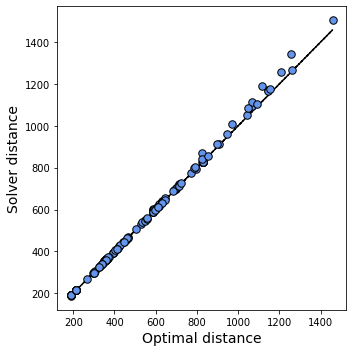

In [44]:
# Print comparison results
print(f"Average deviation: {round(100*(np.mean(df_comparison['ratio'])-1), 2)}%")
print(f"Minimum deviation: {round(100*(np.min(df_comparison['ratio'])-1), 2)}%")
print(f"Maximum deviation: {round(100*(np.max(df_comparison['ratio'])-1), 2)}%")

# Plot comparison
fig, ax = plt.subplots(1, 1, figsize=(5,5))
ax.plot(df_comparison['sol_opt_distance'], df_comparison['sol_opt_distance'], color='k', linestyle='--', zorder=-1)
ax.scatter(df_comparison['sol_opt_distance'], df_comparison['solution_distance'], s=56, c='cornflowerblue', ec='k', zorder=0)
#ax.ticklabel_format(axis="both", style="sci", scilimits=(0, 0))
ax.set_xlabel("Optimal distance", fontsize=14)
ax.set_ylabel("Solver distance", fontsize=14)
plt.tight_layout()
#plt.savefig('solver_performance.eps', format='eps', pad_inches=0.4)
plt.show()

# --> My OR Tools implementation seems to perform well so I can use it for my analysis